# Question 2

In [1]:
# Reading Libraries 
import cv2
import numpy as np 
from matplotlib import pyplot as plt
import pickle
import os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

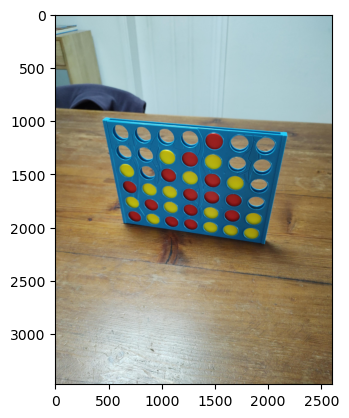

In [2]:
# Read in images 
im_01 = cv2.imread('connect_four_images_A1/004.jpg')
im_01 = cv2.cvtColor(im_01, cv2.COLOR_BGR2RGB)

plt.imshow(im_01)

In [3]:
# Function to warp the image 

def warp_image(im):

    im_hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)

    pixel_colours = im.reshape((im.shape[0]*im.shape[1], 3))
    norm = colors.Normalize(vmin=-1.0,vmax=1.0)
    norm.autoscale(pixel_colours)
    pixel_colours = norm(pixel_colours).tolist()

    # visualise the colours in a RGB colour space
    H, S, V = cv2.split(im_hsv)

    # define lower and upper ranges of HSV to extract blue board 
    lower_hsv = (75,100,10)
    upper_hsv = (105,255,220)

    # Create mask of pixel inside range of lower and upper colours
    mask = cv2.inRange(im_hsv, lower_hsv, upper_hsv) # (Image, lower_bound, upper_bound)

    # Apply mask to visualise
    im_thresh = im.copy()
    im_thresh[(mask==0),:] = (0,0,0)

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    im_contours = im.copy()
    cv2.drawContours(im_contours, contours, -1, (0,255,0), 3) # draw using bright green

    arclength = cv2.arcLength(largest_contour, True)
    epsilon = 0.02 * arclength 
    corners = cv2.approxPolyDP(largest_contour, epsilon, True)
    corners = corners.reshape(-1, 2)

    h = 300
    w = 400

    corner_points_output = np.float32([
        [0, 0],
        [w - 1, 0],
        [w - 1, h - 1],
        [0, h - 1]
    ])

    M = cv2.getPerspectiveTransform(np.float32(corners), corner_points_output)
    warped_image = cv2.warpPerspective(im, M, (w,h))


    return warped_image

In [4]:
# Function to determine image state 

def find_game_state(warped_image): 

    warped_hsv = cv2.cvtColor(warped_image, cv2.COLOR_RGB2HSV)

    H1, S1, V1 = cv2.split(warped_hsv)

    pixel_colours = warped_image.reshape((warped_image.shape[0]*warped_image.shape[1], 3))
    norm = colors.Normalize(vmin=-1.0,vmax=1.0)
    norm.autoscale(pixel_colours)
    pixel_colours = norm(pixel_colours).tolist()

    # fig = plt.figure()
    # axis = fig.add_subplot(1, 1, 1, projection="3d")
    # axis.scatter(H1.flatten(), S1.flatten(), V1.flatten(), facecolors=pixel_colours, marker='.')
    # axis.set_xlabel("Hue")
    # axis.set_ylabel("Saturation")
    # axis.set_zlabel("Value")
    # axis.view_init(10,90) # (elevation, azimuth, roll): try adjusting to view from different perspectives

    # plt.tight_layout()

    # Red mask
    lower1_red = (175,0,0)
    upper1_red = (200,255,255)

    lower2_red = (0,150,0)
    upper2_red = (10,255,255)

    mask1 = cv2.inRange(warped_hsv, lower1_red, upper1_red)
    mask2 = cv2.inRange(warped_hsv, lower2_red, upper2_red)

    red_mask = cv2.bitwise_or(mask1, mask2)


    # Yellow mask
    lower_yellow = (25,170,100)
    upper_yellow = (35,255,250)

    yellow_mask = cv2.inRange(warped_hsv, lower_yellow, upper_yellow) # (Image, lower_bound, upper_bound)

    # # Apply mask to visualise
    im_red = warped_image.copy()
    im_red[(red_mask==0),:] = (0,0,0)

    im_yellow = warped_image.copy()
    im_yellow[(yellow_mask==0),:] = (0,0,0)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
    red_thresh = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)
    red_thresh = cv2.morphologyEx(red_thresh, cv2.MORPH_CLOSE, kernel)

    #Apply contour to find edges of the board 
    red_contours, _ = cv2.findContours(red_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    im_red_contours = warped_image.copy()
    cv2.drawContours(im_red_contours, red_contours, -1, (0,255,0), 3) # draw using bright green

    # plt.subplot(121)
    # plt.imshow(im_red_contours) # show the thresholded image


    yellow_thresh = cv2.morphologyEx(yellow_mask, cv2.MORPH_OPEN, kernel)
    yellow_thresh = cv2.morphologyEx(yellow_thresh, cv2.MORPH_CLOSE, kernel)
    yellow_contours, _ = cv2.findContours(yellow_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    im_yellow_contours = warped_image.copy()
    cv2.drawContours(im_yellow_contours, yellow_contours, -1, (0,255,0), 3) # draw using bright green

    # plt.subplot(122)
    # plt.imshow(im_yellow_contours) # show the thresholded image

    (num_components_red, red_label_img, red_stats, red_centroids) = cv2.connectedComponentsWithStats(red_thresh)

    (num_components_yellow, yellow_label_img, yellow_stats, yellow_centroids) = cv2.connectedComponentsWithStats(yellow_thresh)

    game_state = np.zeros((6, 7))

    row_height = 50 
    col_ranges = [0, 70, 110, 180, 230, 280, 350, 400]

    for i in range(1, num_components_red): 
        cx, cy = red_centroids[i]

        row_num = int(cy // row_height)

        for j in range(len(col_ranges) - 1): 
            if col_ranges[j] <= cx < col_ranges[j+1]:
                col_num = j

        game_state[row_num, col_num] = 2

    for i in range(1, num_components_yellow): 
        cx, cy = yellow_centroids[i]


        row_num = int(cy // row_height)

        for j in range(len(col_ranges) - 1): 
            if col_ranges[j] <= cx < col_ranges[j+1]:
                col_num = j

        game_state[row_num, col_num] = 1


        

    return game_state

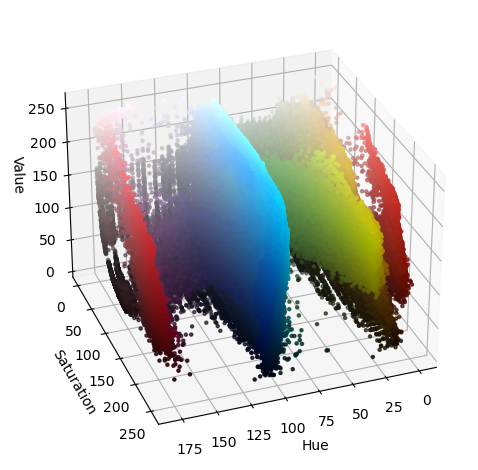

In [5]:


im_01 = cv2.imread('connect_four_images_A1/007.jpg')
im = cv2.cvtColor(im_01, cv2.COLOR_BGR2RGB)

im_hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)

pixel_colours = im.reshape((im.shape[0]*im.shape[1], 3))
norm = colors.Normalize(vmin=-1.0,vmax=1.0)
norm.autoscale(pixel_colours)
pixel_colours = norm(pixel_colours).tolist()

# visualise the colours in a RGB colour space
H, S, V = cv2.split(im_hsv)

fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(H.flatten(), S.flatten(), V.flatten(), facecolors=pixel_colours, marker='.')
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
axis.view_init(30,70) # (elevation, azimuth, roll): try adjusting to view from different perspectives

plt.tight_layout()



# Apply a colour threshold 

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
# thresh_im2 = cv2.morphologyEx(thresh_im1, cv2.MORPH_OPEN, kernel)
# thresh_im2 = cv2.morphologyEx(thresh_im2, cv2.MORPH_CLOSE, kernel)

# Calculate contours in the binary image
# contours, hierarchy = cv2.findContours(thresh_im2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# # draw these contours to the image and display the number of extracted contours
# im_temp = thresh_im2.copy()
# im_temp = cv2.cvtColor(im_temp, cv2.COLOR_GRAY2RGB)
# cv2.drawContours(im_temp, contours, -1, (0,255,0), 3) # draw using bright green

# plt.imshow(im_temp, 'gray') # show the thresholded image

# print("Number of contours found: %d"%(len(contours)))

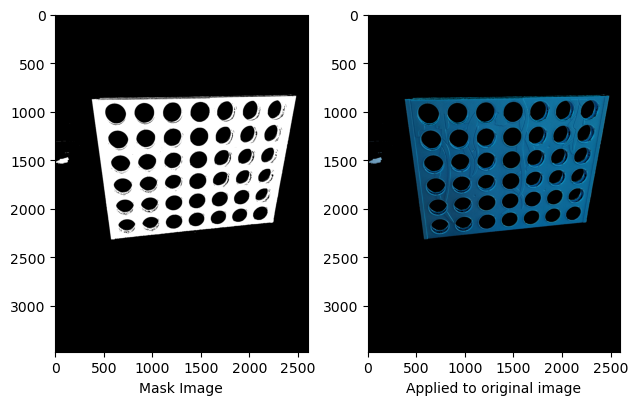

In [6]:
# Define a mask for the blue 

# define lower and upper ranges of HSV to extract blue board 
lower_hsv = (75,100,10)
upper_hsv = (105,255,220)

# Create mask of pixel inside range of lower and upper colours
mask = cv2.inRange(im_hsv, lower_hsv, upper_hsv) # (Image, lower_bound, upper_bound)

# Apply mask to visualise
im_thresh = im.copy()
im_thresh[(mask==0),:] = (0,0,0)
#im_temp = cv2.bitwise_and(im, im, mask=mask) # alternative way

# Display image and mask
plt.subplot(121)
plt.imshow(mask, 'gray')
plt.xlabel('Mask Image')

plt.subplot(122)
plt.imshow(im_thresh)
plt.xlabel('Applied to original image')

plt.tight_layout()

[[[2475  839]]

 [[ 379  875]]

 [[ 576 2312]]

 [[2239 2139]]]


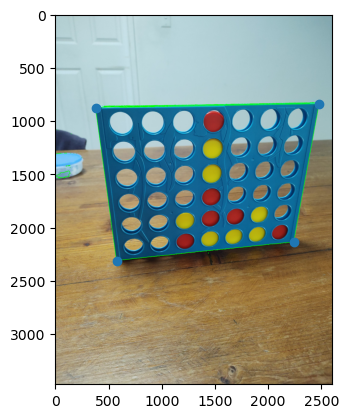

In [7]:
# Apply contour to find edges of the board 
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
im_contours = im.copy()
cv2.drawContours(im_contours, contours, -1, (0,255,0), 3) # draw using bright green

plt.imshow(im_contours) # show the thresholded image


arclength = cv2.arcLength(largest_contour, True)
epsilon = 0.02 * arclength 
approx_corners = cv2.approxPolyDP(largest_contour, epsilon, True)
print(approx_corners)
approx_corners = approx_corners.reshape(-1, 2)


x = approx_corners[:,0]
y = approx_corners[:,1]

plt.scatter(x, y)

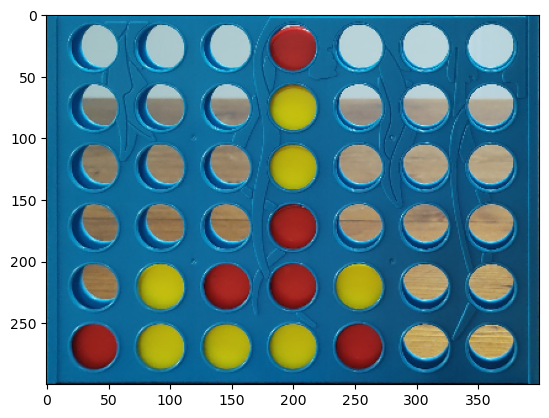

In [8]:
# Apply perspective transformation to the board

h = 300
w = 400

corner_points_output = np.float32([
    [0, 0],
    [w - 1, 0],
    [w - 1, h - 1],
    [0, h - 1]
])

M = cv2.getPerspectiveTransform(np.float32(approx_corners), corner_points_output)
warped_image = cv2.warpPerspective(im, M, (w,h))

plt.imshow(warped_image)


[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 1. 2. 2. 0. 0.]
 [0. 0. 2. 1. 1. 0. 0.]
 [0. 1. 2. 2. 1. 1. 0.]]


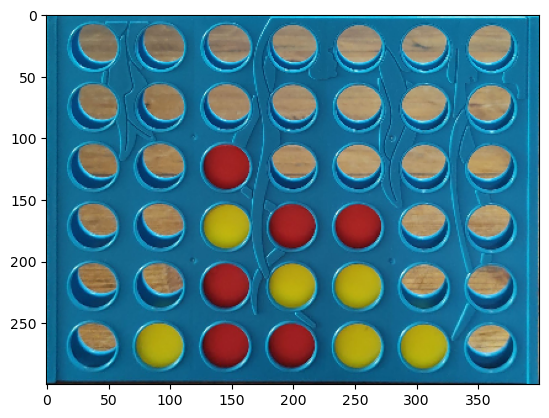

In [9]:
# Finding the game state 

im_01 = cv2.imread('connect_four_images_A1/014.jpg')
im = cv2.cvtColor(im_01, cv2.COLOR_BGR2RGB)

warped_image = warp_image(im)

plt.imshow(warped_image)

game_state = find_game_state(warped_image)

print(game_state)


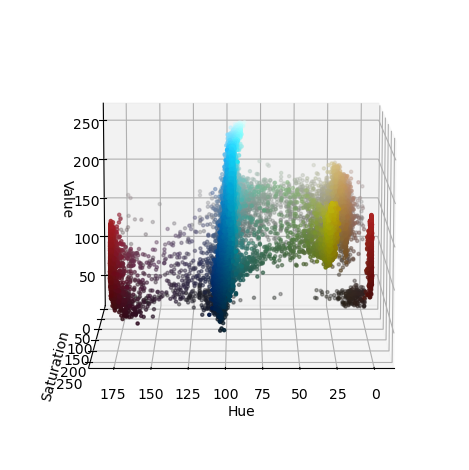

In [10]:
# contour red tokens and find centroid. then map centroid to a cell 

warped_hsv = cv2.cvtColor(warped_image, cv2.COLOR_RGB2HSV)

H1, S1, V1 = cv2.split(warped_hsv)

pixel_colours = warped_image.reshape((warped_image.shape[0]*warped_image.shape[1], 3))
norm = colors.Normalize(vmin=-1.0,vmax=1.0)
norm.autoscale(pixel_colours)
pixel_colours = norm(pixel_colours).tolist()

fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(H1.flatten(), S1.flatten(), V1.flatten(), facecolors=pixel_colours, marker='.')
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
axis.view_init(10,90) # (elevation, azimuth, roll): try adjusting to view from different perspectives

plt.tight_layout()

# Red mask
lower1_red = (175,0,0)
upper1_red = (200,255,255)

lower2_red = (0,150,0)
upper2_red = (10,255,255)

mask1 = cv2.inRange(warped_hsv, lower1_red, upper1_red)
mask2 = cv2.inRange(warped_hsv, lower2_red, upper2_red)

red_mask = cv2.bitwise_or(mask1, mask2)


# Yellow mask
lower_yellow = (25,170,100)
upper_yellow = (35,255,250)

yellow_mask = cv2.inRange(warped_hsv, lower_yellow, upper_yellow) # (Image, lower_bound, upper_bound)

# # Apply mask to visualise
im_red = warped_image.copy()
im_red[(red_mask==0),:] = (0,0,0)

im_yellow = warped_image.copy()
im_yellow[(yellow_mask==0),:] = (0,0,0)



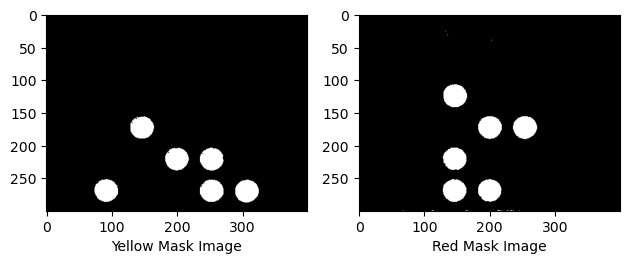

In [11]:
# Display image and mask
plt.subplot(121)
plt.imshow(yellow_mask, 'gray')
plt.xlabel('Yellow Mask Image')

plt.subplot(122)
plt.imshow(red_mask, 'gray')
plt.xlabel('Red Mask Image')

plt.tight_layout()

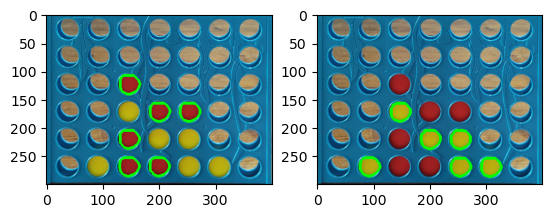

In [12]:
# Find centroids of red and yellow 

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
red_thresh = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)
red_thresh = cv2.morphologyEx(red_thresh, cv2.MORPH_CLOSE, kernel)

 #Apply contour to find edges of the board 
red_contours, _ = cv2.findContours(red_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

im_red_contours = warped_image.copy()
cv2.drawContours(im_red_contours, red_contours, -1, (0,255,0), 3) # draw using bright green

plt.subplot(121)
plt.imshow(im_red_contours) # show the thresholded image


yellow_thresh = cv2.morphologyEx(yellow_mask, cv2.MORPH_OPEN, kernel)
yellow_thresh = cv2.morphologyEx(yellow_thresh, cv2.MORPH_CLOSE, kernel)
yellow_contours, _ = cv2.findContours(yellow_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

im_yellow_contours = warped_image.copy()
cv2.drawContours(im_yellow_contours, yellow_contours, -1, (0,255,0), 3) # draw using bright green

plt.subplot(122)
plt.imshow(im_yellow_contours) # show the thresholded image

(num_components_red, red_label_img, red_stats, red_centroids) = cv2.connectedComponentsWithStats(red_thresh)

(num_components_yellow, yellow_label_img, yellow_stats, yellow_centroids) = cv2.connectedComponentsWithStats(yellow_thresh)


In [13]:
# Map centroids to a position 

game_state = np.zeros((6, 7))

row_height = 50 
col_ranges = [0, 70, 110, 180, 230, 280, 350, 400]

for i in range(1, num_components_red): 
    cx, cy = red_centroids[i]

    row_num = int(cy // row_height)

    for j in range(len(col_ranges) - 1): 
        if col_ranges[j] <= cx < col_ranges[j+1]:
            col_num = j

    game_state[row_num, col_num] = 2

for i in range(1, num_components_yellow): 
    cx, cy = yellow_centroids[i]


    row_num = int(cy // row_height)

    for j in range(len(col_ranges) - 1): 
        if col_ranges[j] <= cx < col_ranges[j+1]:
            col_num = j

    game_state[row_num, col_num] = 1

print(game_state)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 1. 2. 2. 0. 0.]
 [0. 0. 2. 1. 1. 0. 0.]
 [0. 1. 2. 2. 1. 1. 0.]]


In [ ]:
# Checking the accuracy of the algorithm 
# Need
#       1. Board Accuracy 
#       2. Average Board Accuracy 
#       3. Overall Accuracy
#       4. Board Location Accuracy 

import pickle



def find_board_accuracy(validation_data, image_label, image_result):

    total_cells = 6*7

    correct_array = validation_data[image_label]

    num_correct = np.sum(correct_array == image_result)

    board_accuracy = num_correct/total_cells

    return board_accuracy

# Now `data` contains the unpickled Python object
print(data['001.jpg'])


[[0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 2 0 2 0 0 0]
 [0 1 1 2 0 0 0]
 [0 1 2 2 0 0 0]
 [1 1 2 1 0 0 0]]


In [ ]:
with open('assign1Q2_validationdata/board_states.pkl', 'rb') as f:
        validation_data = pickle.load(f)

        